In [3]:
import tqdm

import h5py
import numpy as np
import matplotlib.pyplot as plt
import corner
import scipy.interpolate as interpolate

from fiesta.train.DataManager import DataManager
from fiesta.train.AfterglowData import RunPyblastafterglow

file = "./model/pyblastafterglow_raw_data.h5"
fix_file = "./model/fix_file_early_times.h5"

In [126]:
with h5py.File(fix_file, "r") as f:
    problematic_train_X = f["train"]["X"][:]
    problematic_val_X = f["val"]["X"][:]
    problematic_test_X = f["test"]["X"][:]

    
    print("train is nan? inf?", np.any(np.isnan(f["train"]["y"])), np.any(np.isinf(f["train"]["y"])))
    print("val is nan? inf?", np.any(np.isnan(f["val"]["y"])), np.any(np.isinf(f["val"]["y"])))
    print("test is nan? inf?", np.any(np.isnan(f["test"]["y"])), np.any(np.isinf(f["test"]["y"])))


train is nan? inf? True True
val is nan? inf? False True
test is nan? inf? True False


In [139]:
with h5py.File(fix_file, "r") as f:
    train_nans = np.unique(np.where(np.isnan(f["train"]["y"]))[0])

In [63]:
def find_old_ind(X_old, X):

    inds = []

    for x in X:
        inds.append(np.where(X_old == x)[0][0])
    
    return np.array(inds)


with h5py.File(file, "r+") as f:
    problematic_train_ind = find_old_ind(f["train"]["X"][:], problematic_train_X)
    problematic_val_ind = find_old_ind(f["val"]["X"][:], problematic_val_X)
    problematic_test_ind = find_old_ind(f["test"]["X"][:], problematic_test_X)



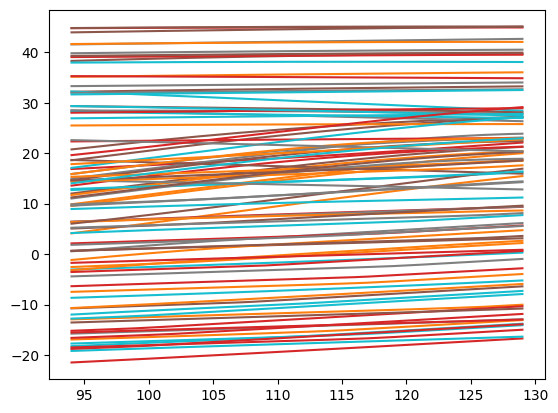

In [142]:
for ind in train_nans:

    with h5py.File(fix_file, "r") as f:
        y = f["train"]["y"][ind]
    
    with h5py.File(file, "r") as f:
        problematic_y = f["train"]["y"][problematic_train_ind[ind]]
    
    plt.plot(y[:93])
    plt.plot(problematic_y[:130])
plt.show()

## OVERWRITE

In [170]:
with h5py.File(file, "r+") as f:
    
    y_old = f["train"]["y"][np.sort(problematic_train_ind)].reshape(-1, f["nus"].shape[0], f["times"].shape[0])

    with h5py.File(fix_file, "r") as fix_f:
        y_new = (fix_f["train"]["y"][:])[np.argsort(problematic_train_ind)].reshape(-1, 256, 94)

    nan_inds = np.unique(np.where(np.isnan(y_new))[0])
    interp_nans = interpolate.interp1d(x=np.log10(f["times"][94:]), y=y_old[nan_inds,:,94:], axis=-1, fill_value="extrapolate")
    y_new[nan_inds] = interp_nans(np.log10(f["times"][:94]))
    
    y_new = np.maximum(-50, y_new)
    y_old[:,:,:94] = y_new

    f["train"]["y"][np.sort(problematic_train_ind)] = y_old.reshape(-1, f["nus"].shape[0]*f["times"].shape[0])

In [169]:
with h5py.File(file, "r+") as f:
    
    y_old = f["val"]["y"][np.sort(problematic_val_ind)].reshape(-1, f["nus"].shape[0], f["times"].shape[0])

    with h5py.File(fix_file, "r") as fix_f:
        y_new = (fix_f["val"]["y"][:])[np.argsort(problematic_val_ind)].reshape(-1, 256, 94)
    
    nan_inds = np.unique(np.where(np.isnan(y_new))[0])
    interp_nans = interpolate.interp1d(x=np.log10(f["times"][94:]), y=y_old[nan_inds,:,94:], axis=-1, fill_value="extrapolate")
    y_new[nan_inds] = interp_nans(np.log10(f["times"][:94]))
    
    y_new = np.maximum(-50, y_new)
    y_old[:,:,:94] = y_new

    f["val"]["y"][np.sort(problematic_val_ind)] = y_old.reshape(-1, f["nus"].shape[0]*f["times"].shape[0])

In [168]:
with h5py.File(file, "r+") as f:
    
    y_old = f["test"]["y"][np.sort(problematic_test_ind)].reshape(-1, f["nus"].shape[0], f["times"].shape[0])

    with h5py.File(fix_file, "r") as fix_f:
        y_new = (fix_f["test"]["y"][:])[np.argsort(problematic_test_ind)].reshape(-1, 256, 94)
    
    nan_inds = np.unique(np.where(np.isnan(y_new))[0])
    interp_nans = interpolate.interp1d(x=np.log10(f["times"][94:]), y=y_old[nan_inds,:,94:], axis=-1, fill_value="extrapolate")
    y_new[nan_inds] = interp_nans(np.log10(f["times"][:94]))
    
    y_new = np.maximum(-50, y_new)
    y_old[:,:,:94] = y_new

    f["test"]["y"][np.sort(problematic_test_ind)] = y_old.reshape(-1, f["nus"].shape[0]*f["times"].shape[0])

## Check overwritten h5 file

In [250]:
with h5py.File(file) as f:
    problematic_ind = np.where(np.abs(f["train"]["y"][:, 94] - f["train"]["y"][:, 93])>0.33)[0]
    problematic_train_X = f["train"]["X"][problematic_ind]

    problematic_ind = np.where(np.abs(f["val"]["y"][:, 94] - f["val"]["y"][:, 93])>0.33)[0]
    problematic_val_X = f["val"]["X"][problematic_ind]

    problematic_ind = np.where(np.abs(f["test"]["y"][:, 94] - f["test"]["y"][:, 93])>0.33)[0]
    problematic_test_X = f["test"]["X"][problematic_ind]

In [211]:
data = DataManager(file, 
                   n_training=10_000,
                   n_val=7500,
                   tmin=1e-4,
                   tmax=2000,
                   numin=1e9,
                   numax=2.5e19,
                   )

data.load_raw_data_from_file()

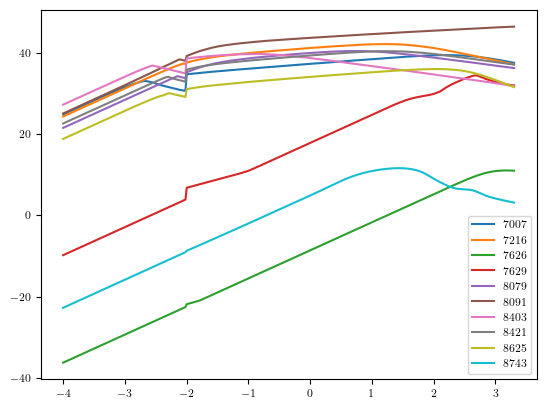

In [248]:
problematic_ind = np.where(np.abs(data.train_y_raw[:, 94] - data.train_y_raw[:, 93])>0.33)[0]


for j in problematic_ind[40:50]:
    plt.plot(np.log10(data.times), (data.train_y_raw[j]).reshape(data.n_nus, data.n_times)[0], label=f"{j}")
plt.legend()

In [243]:

pbag = RunPyblastafterglow(jet_type=0,
                           times=data.times[data.times<1e1],
                           nus=data.nus[:3],
                           parameter_names=data.parameter_names,
                           X = [data.train_X_raw[problematic_ind[18]]],
                           tb0=1e-4,
                           tb1=1e10,
                           ntb=900,
                           path_to_exec="/home/aya/work/hkoehn/fiesta/PyBlastAfterglowMag/src/pba.out",
                           loglevel="info")
_, log_mJys = pbag(0)

[ INFO    ] : [ main.cpp:149 ] : Computation tgrid = [0.0001, 9.64816e+09] n=900
[ INFO    ] : [ main.cpp:151 ] : Output      tgrid = [0.0001, 9.64816e+09] n=900
[ INFO    ] : [ model_magnetar.h:569 ] : Magnetar is not initialized and will not be considered.
 mom=228.858 Gamma=228.861 beta=0.99999
 mom=211.448 Gamma=211.45 beta=0.999989
 mom=180.515 Gamma=180.518 beta=0.999985
 mom=142.428 Gamma=142.431 beta=0.999975
 mom=103.907 Gamma=103.911 beta=0.999954
 mom=70.1538 Gamma=70.161 beta=0.999898
 mom=43.9163 Gamma=43.9277 beta=0.999741
 mom=25.5895 Gamma=25.609 beta=0.999237
 mom=13.9939 Gamma=14.0296 beta=0.997456
 mom=7.3034 Gamma=7.37154 beta=0.990756
 mom=3.7465 Gamma=3.87766 beta=0.966175
 mom=1.96 Gamma=2.20036 beta=0.890762
[ INFO    ] : [ ejecta_id.h:220 ] :  1D ID has theta_wing=0.445085 theta_core=0.131557
[ INFO    ] : [ ejecta_id.h:279 ] : Initial data loaded with nshells=1 m_nlayers=12
[ INFO    ] : [ ejecta_id.h:301 ] : Angular grids are initialized. nshells=1 m_nlayers=

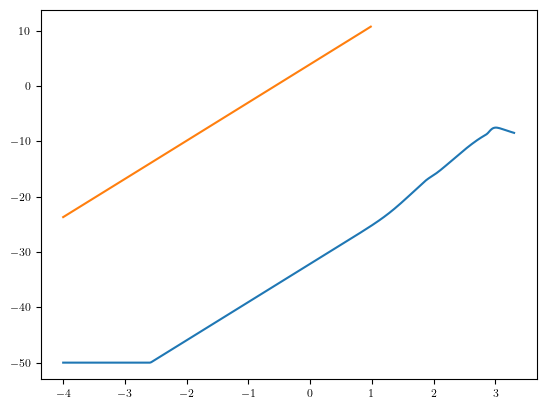

In [254]:
plt.plot(np.log10(data.times), (data.train_y_raw[problematic_ind[18]]).reshape(data.n_nus, data.n_times)[0])
plt.plot(np.log10(data.times[data.times<1e1]), log_mJys.reshape(3, np.sum(data.times<1e1))[0])


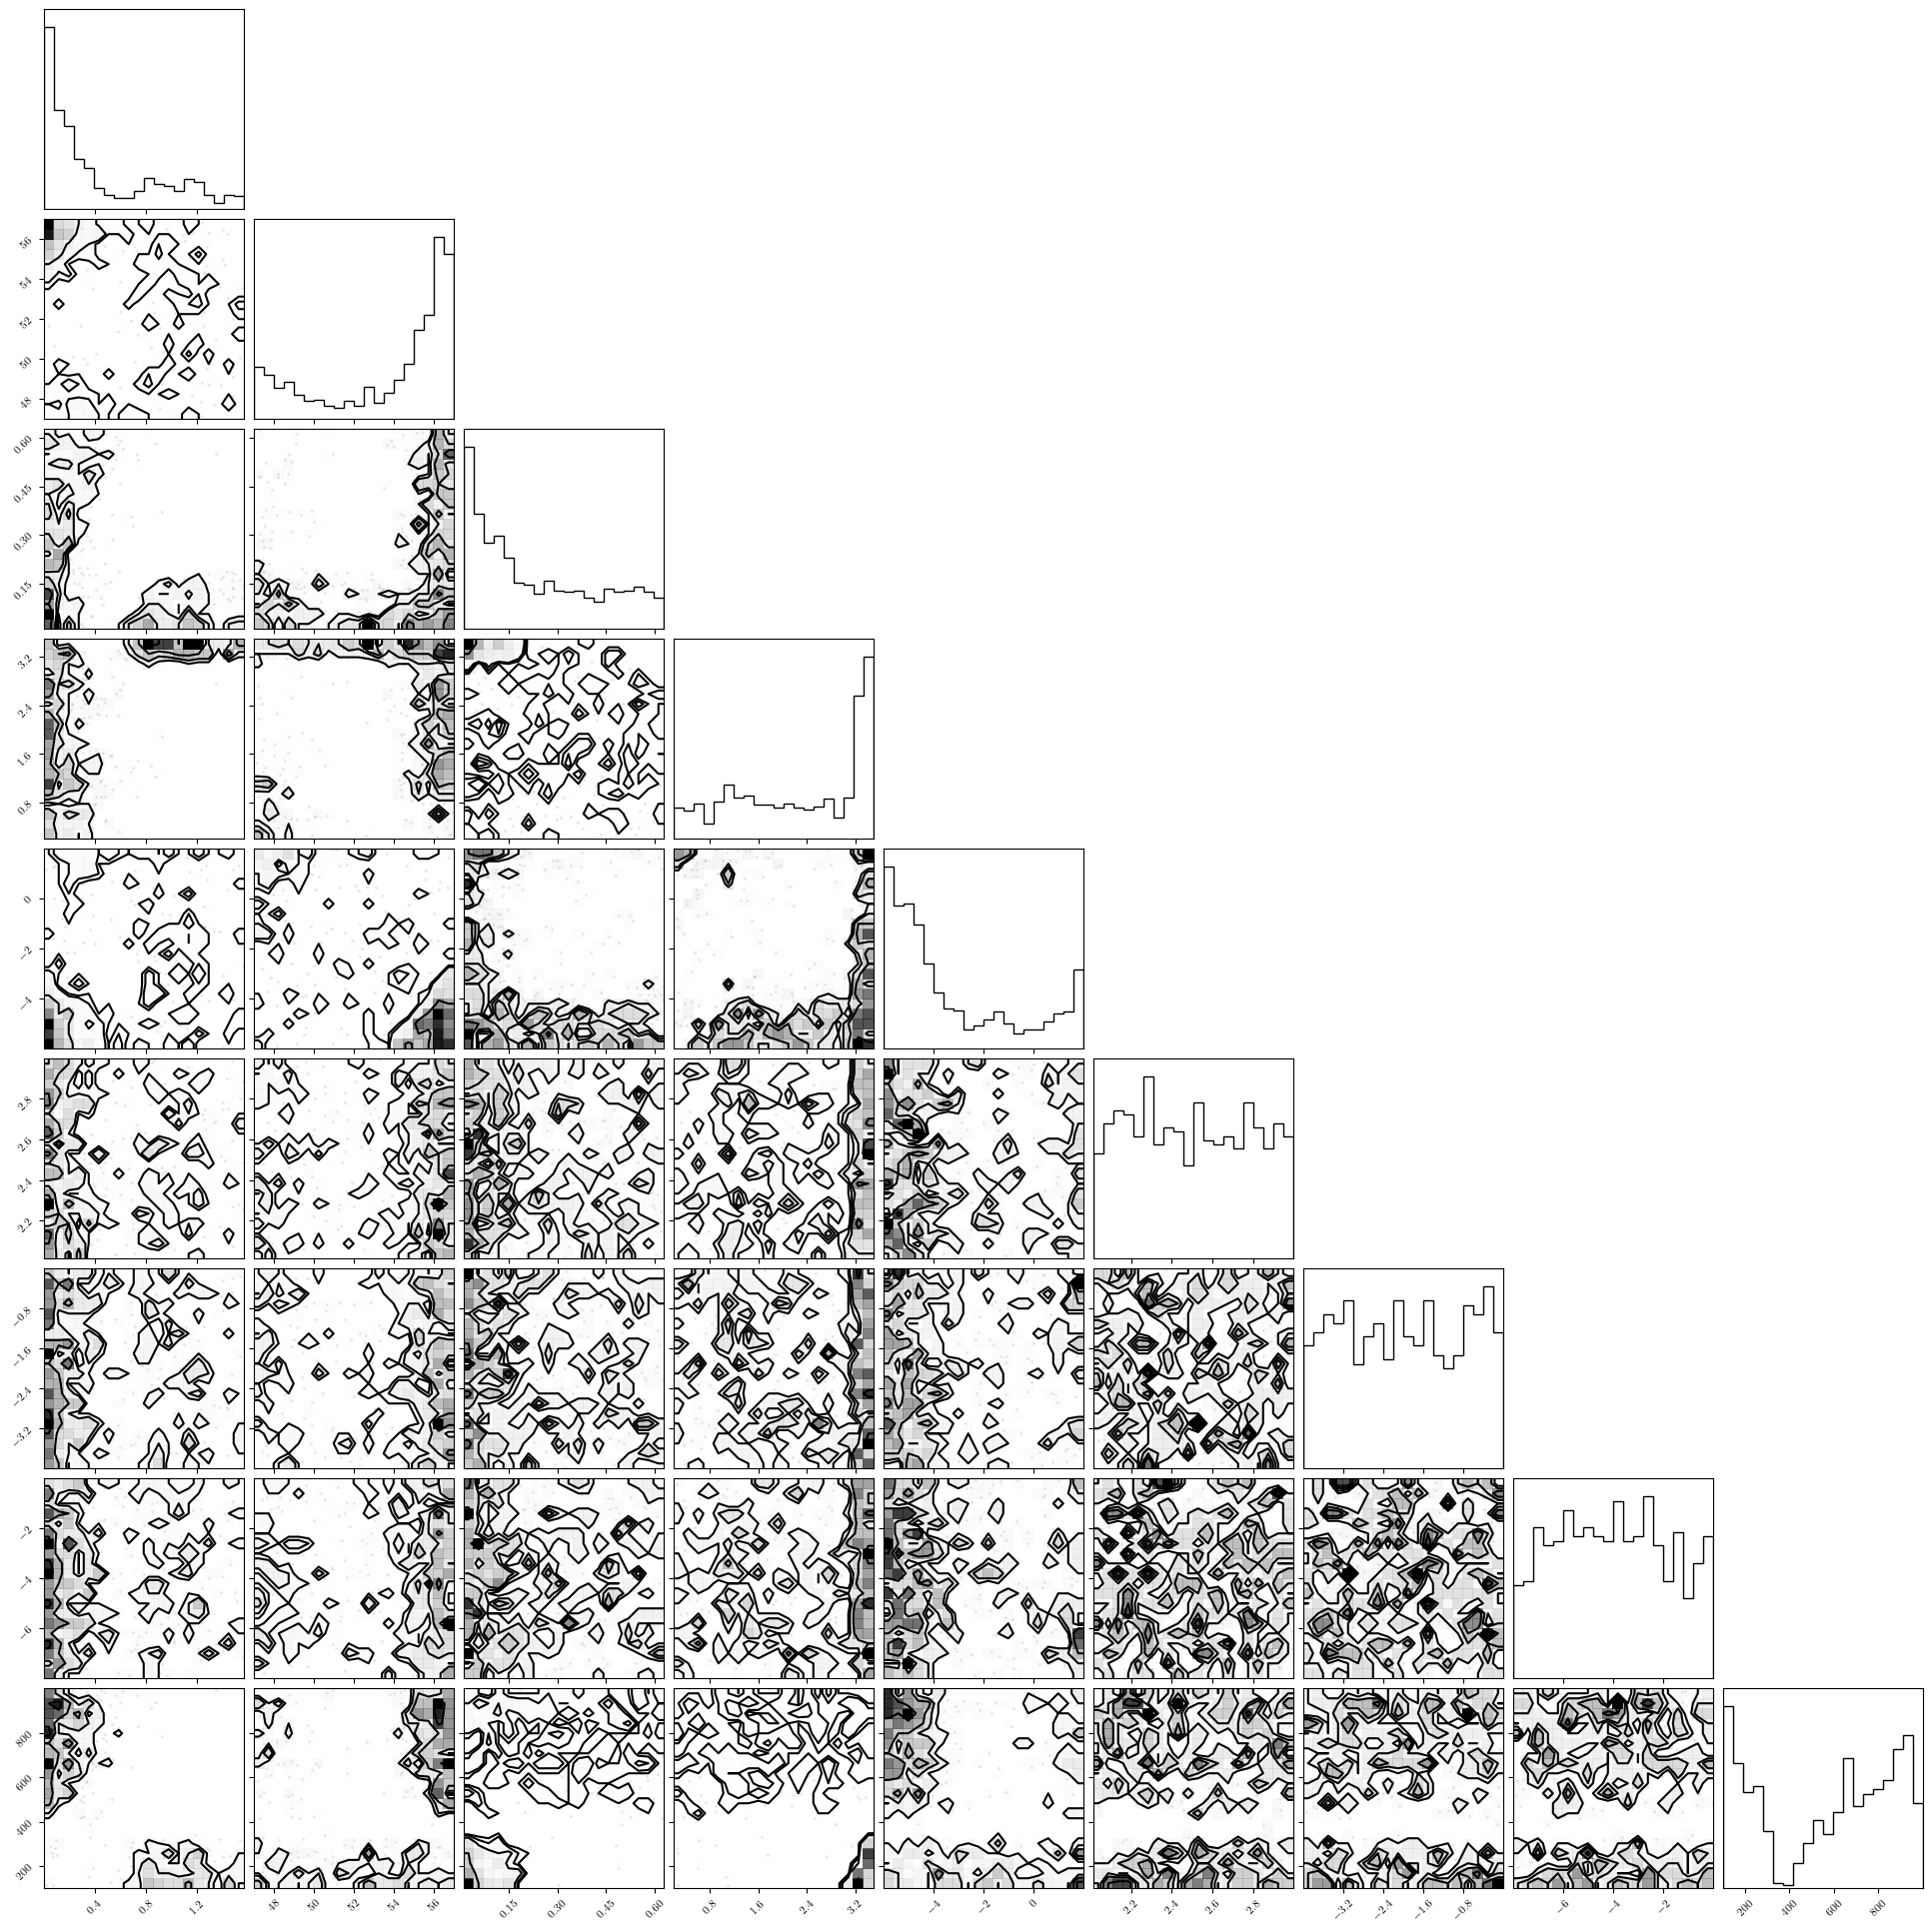

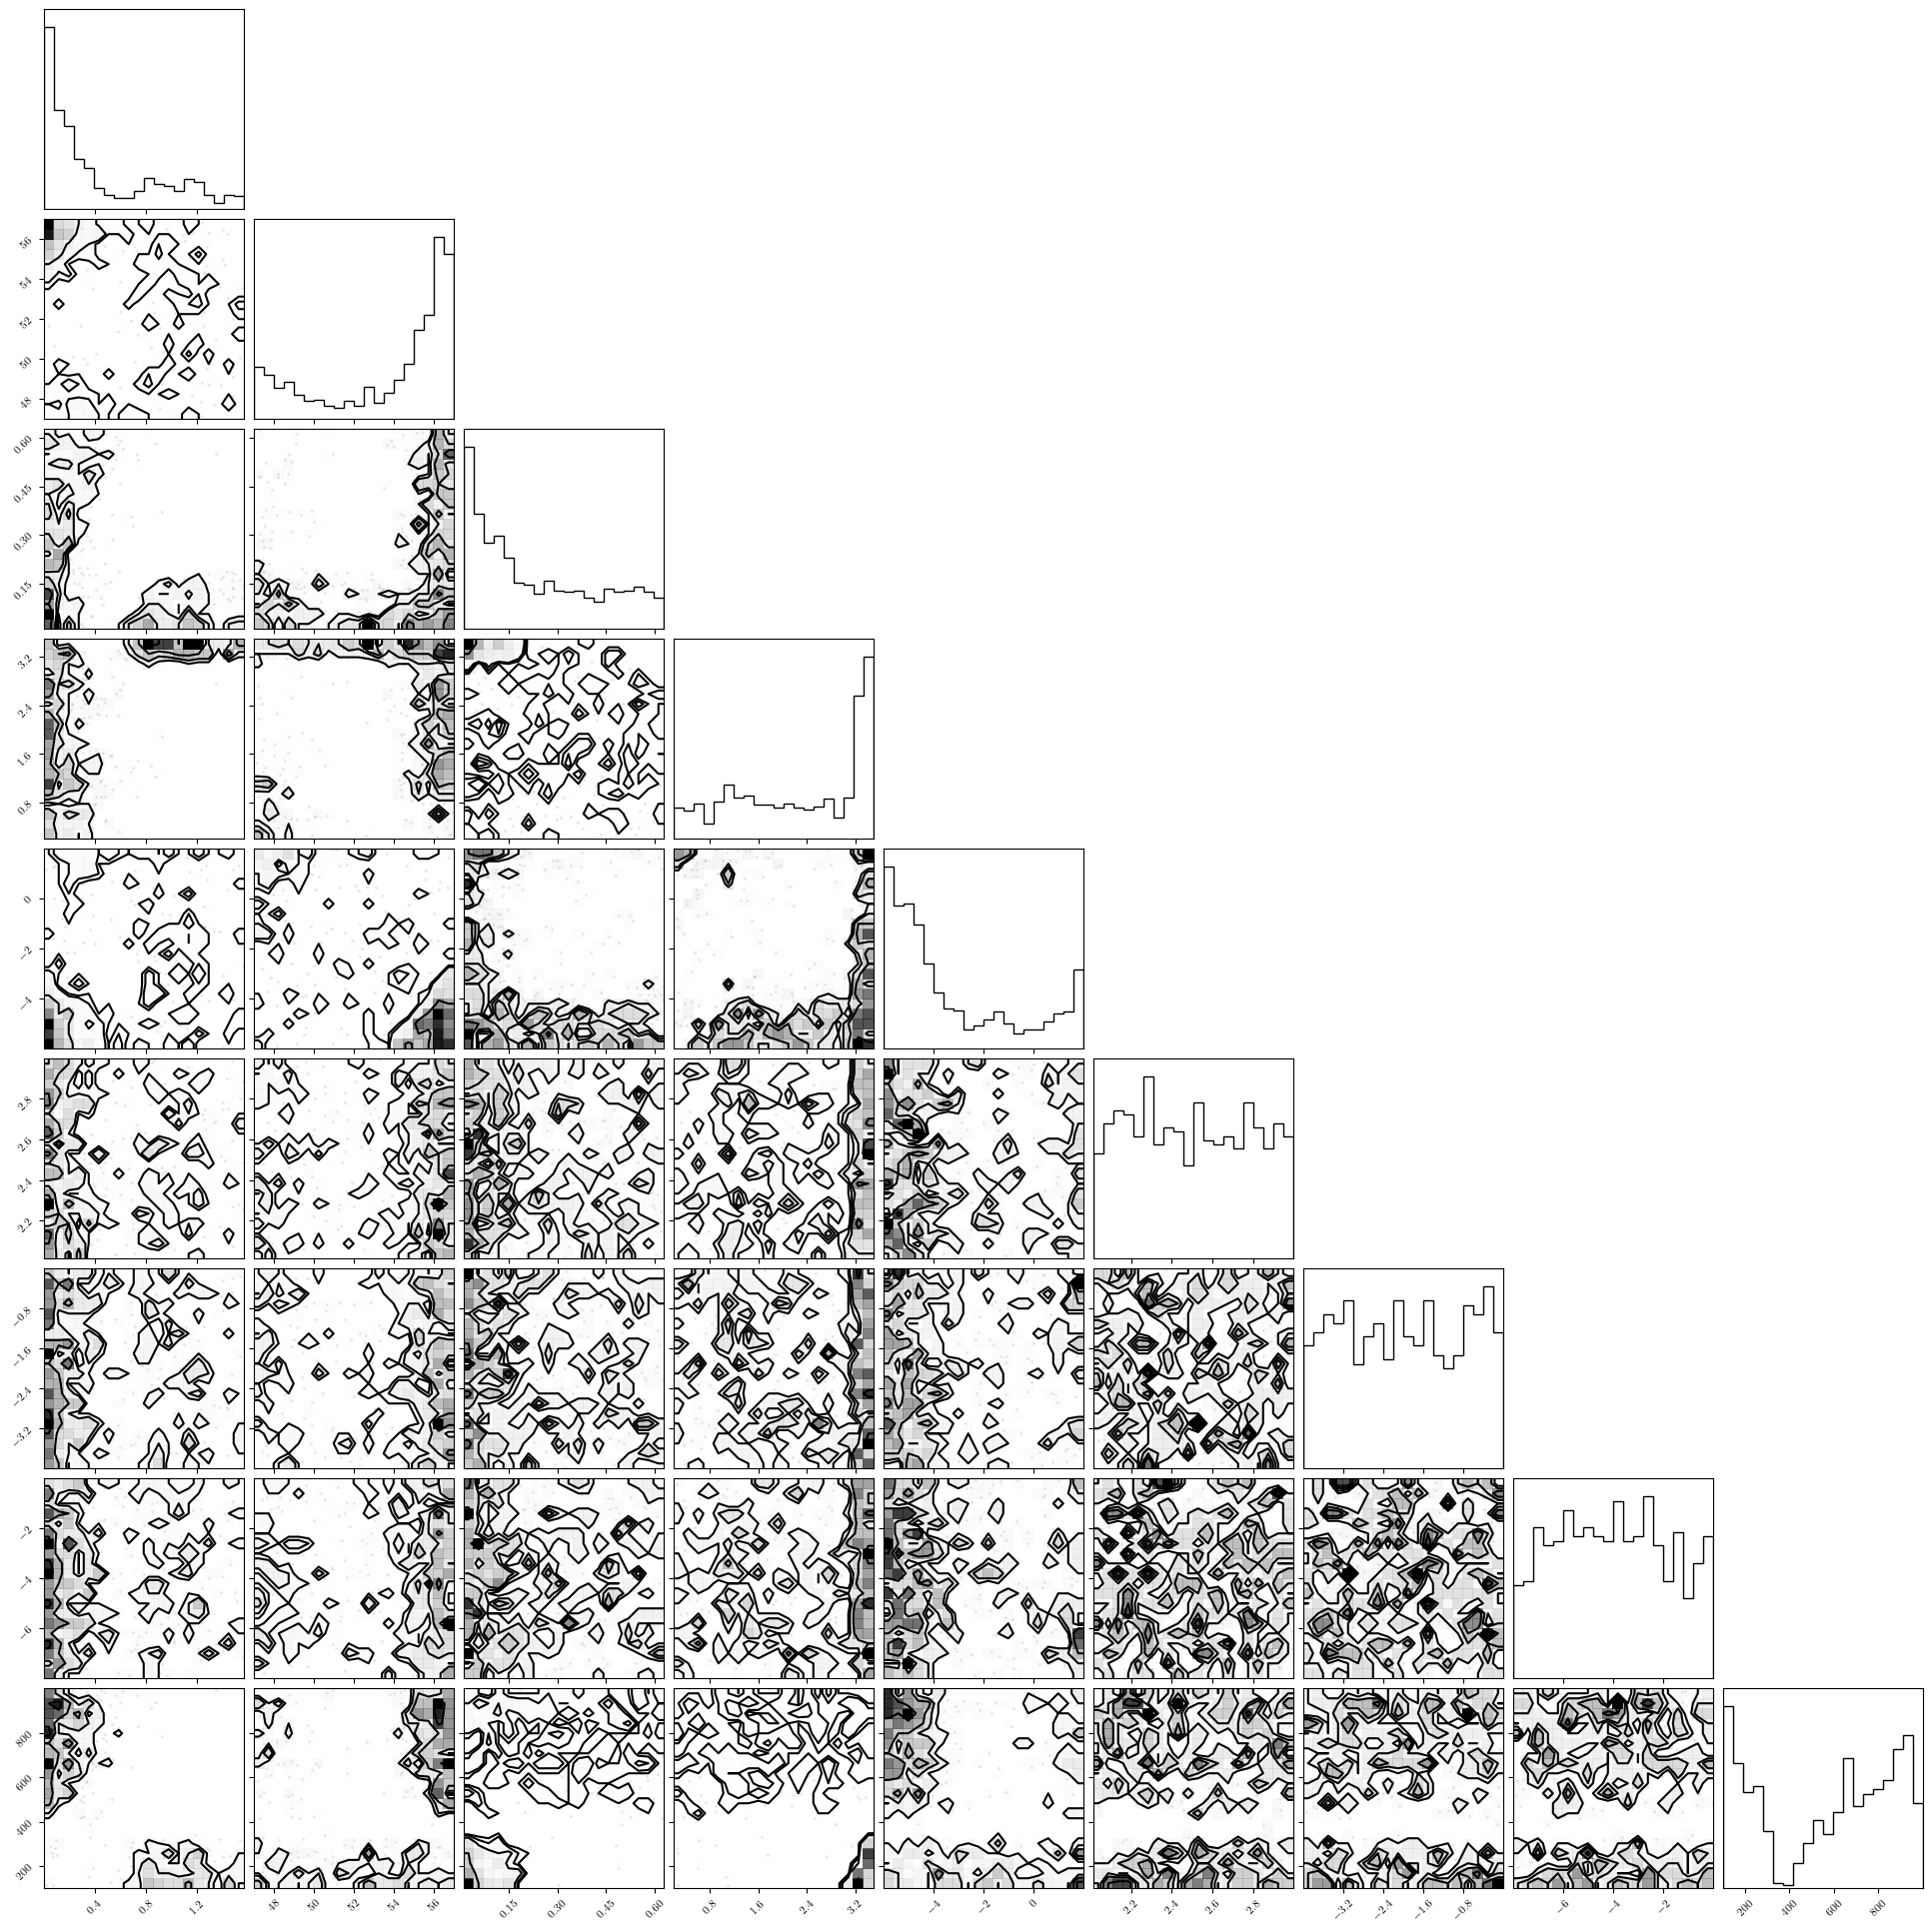

In [210]:
corner.corner(problematic_train_X)